# Pre-Processing dataset

We create a KG in NetworkX-arangoDB

This requires downloading multi-modality datasets from [Bio Snap](https://snap.stanford.edu/biodata/) and other data source. This notebook does simple data engineering before pushing into ArangoDB to create a fully connected network.

##### Modalities:
- Drug-Drug interaction with side-effects
- Drug-Gene interaction
- Disease-Drug interaction
- Disease-Disease interaction
- Disease-Function interaction
- Function-Function interaction
- Gene-Function interaction
- Gene-Gene interaction
- Gene-Protien interaction
- Genomic Region-Genomic Region interaction
- Protien-Protien interaction
- Protien-Protien-Tissue interaction
- Tissue-Function-Gene interaction

In [11]:
!pip install networkx pandas arango matplotlib
!pip install nx-arangodb


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
# Interactions

!wget -nc https://snap.stanford.edu/biodata/datasets/10001/files/ChCh-Miner_durgbank-chem-chem.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10002/files/ChG-Miner_miner-chem-gene.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10004/files/DCh-Miner_miner-disease-chemical.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10006/files/DD-Miner_miner-disease-disease.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10019/files/DF-Miner_miner-disease-function.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10020/files/DG-Miner_miner-disease-gene.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10026/files/FF-Miner_miner-func-func.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10024/files/GF-Miner_miner-gene-function.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10027/files/GP-Miner_miner-gene-protein.tsv.gz
!wget -nc https://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/latest/chembl_35_chemreps.txt.gz # Chemical Representations
#!wget -nc https://snap.stanford.edu/biodata/datasets/10028/files/PP-Miner_miner-ppi.tsv.gz
#!wget -nc https://snap.stanford.edu/biodata/datasets/10032/files/GG-NE.tar.gz

# Entities and Feature tables

!wget -nc https://snap.stanford.edu/biodata/datasets/10021/files/D-DoMiner_miner-diseaseDOID.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10003/files/D-MeshMiner_miner-disease.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10025/files/D-OmimMiner_miner-diseaseOMIM.tsv.gz
!wget -nc https://snap.stanford.edu/biodata/datasets/10022/files/G-SynMiner_miner-geneHUGO.tsv.gz

File ‘ChCh-Miner_durgbank-chem-chem.tsv.gz’ already there; not retrieving.

File ‘ChG-Miner_miner-chem-gene.tsv.gz’ already there; not retrieving.

File ‘DCh-Miner_miner-disease-chemical.tsv.gz’ already there; not retrieving.

File ‘DD-Miner_miner-disease-disease.tsv.gz’ already there; not retrieving.

File ‘DF-Miner_miner-disease-function.tsv.gz’ already there; not retrieving.

File ‘DG-Miner_miner-disease-gene.tsv.gz’ already there; not retrieving.

File ‘FF-Miner_miner-func-func.tsv.gz’ already there; not retrieving.

File ‘GF-Miner_miner-gene-function.tsv.gz’ already there; not retrieving.

File ‘GP-Miner_miner-gene-protein.tsv.gz’ already there; not retrieving.

File ‘chembl_35_chemreps.txt.gz’ already there; not retrieving.

File ‘D-DoMiner_miner-diseaseDOID.tsv.gz’ already there; not retrieving.

File ‘D-MeshMiner_miner-disease.tsv.gz’ already there; not retrieving.

File ‘D-OmimMiner_miner-diseaseOMIM.tsv.gz’ already there; not retrieving.

File ‘G-SynMiner_miner-geneHUGO.tsv.g

In [13]:
import networkx as nx
import pandas as pd
import nx_arangodb as nxadb
import requests
from arango import ArangoClient
import matplotlib.pyplot as plt
import os

os.environ["DATABASE_HOST"] = "http://localhost:8529"  # Replace with your ArangoDB host
os.environ["DATABASE_USERNAME"] = "root"               # Replace with your ArangoDB username
os.environ["DATABASE_PASSWORD"] = "openSesame"         # Replace with your ArangoDB password
os.environ["DATABASE_NAME"] = "NeuThera"               

### Loading Dataset

#### Entities and Feature Tables

In [14]:
# Disease DOID Synopses

Doid = pd.read_csv(
    "./D-DoMiner_miner-diseaseDOID.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["doid", "name", "definition", "synonym"],
)

Doid

,doid,name,definition,synonym
0,DOID:0001816,angiosarcoma,A malignant vascular tumor that results_in rap...,hemangiosarcoma EXACT []
1,DOID:0002116,pterygium,NaN,surfer's eye EXACT []
2,DOID:0014667,disease of metabolism,A disease that involving errors in metabolic p...,metabolic disease EXACT [SNOMEDCT_2005_07_31:...
3,DOID:0050001,Actinomadura madurae infectious disease,NaN,NaN
4,DOID:0050002,Actinomadura pelletieri infectious disease,NaN,NaN
...,...,...,...,...
9242,DOID:9989,metastasis to the orbit,NaN,secondary malignant neoplasm of orbit (disorde...
9243,DOID:999,eosinophilia,NaN,Eosinophilic leukocytosis EXACT [MTHICD9_2006:...
9244,DOID:9993,hypoglycemia,NaN,Hypoglycaemia EXACT [SNOMEDCT_2005_07_31:15469...
9245,DOID:9995,endocrine and metabolic disturbances specific ...,NaN,NaN


In [74]:
# Disease MESH Synopses

Mesh = pd.read_csv(
    "./D-MeshMiner_miner-disease.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "name", "definition", "synonym"],
)

Mesh

,mesh,name,definition,synonym
0,MESH:C538288,10p Deletion Syndrome (Partial),NaN,"Chromosome 10, 10p- Partial|Chromosome 10, mon..."
1,MESH:C535484,13q deletion syndrome,NaN,Chromosome 13q deletion|Chromosome 13q deletio...
2,MESH:C579849,15q24 Microdeletion,NaN,15q24 Deletion|15q24 Microdeletion Syndrome|In...
3,MESH:C579850,16p11.2 Deletion Syndrome,NaN,NaN
4,MESH:C567076,"17,20-Lyase Deficiency, Isolated",NaN,"17-Alpha-Hydroxylase-17,20-Lyase Deficiency, C..."
...,...,...,...,...
11327,MESH:C536729,Zunich neuroectodermal syndrome,NaN,CHIME syndrome
11328,MESH:C536730,Zuska's Disease,NaN,Lactation and squamous metaplasia of lactifero...
11329,MESH:C565223,Zygodactyly 1,NaN,ZD1
11330,MESH:D015051,Zygomatic Fractures,Fractures of the zygoma.,"Fractures, Zygomatic|Fracture, Zygomatic|Zygom..."


In [15]:
# OMIM Genetic Disorders

Omim = pd.read_csv(
    "./D-OmimMiner_miner-diseaseOMIM.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["omim", "phenotypes", "gene_name", "gene", "location", "_"],
)

Omim = Omim.iloc[:, :-1]

Omim

,omim,phenotypes,gene_name,gene,location
0,OMIM:115665,"Cataract 8, multiple types (2)","Cataract, congenital, Volkmann type","CTRCT8, CCV",1pter-p36.13
1,OMIM:607671,"Dystonia 13, torsion (2)","Dystonia 13, torsion",DYT13,1p36.32-p36.13
2,OMIM:606242,Kondoh syndrome (2),"Kondoh syndrome (mental retardation, microceph...",KONDS,1p36.32-p35.3
3,OMIM:614414,"Deafness, autosomal recessive 96 (2)","Deafness, autosomal recessive 96",DFNB96,1p36.31-p36.13
4,OMIM:609918,Gallbladder disease 2 (2),Gallbladder disease 2,GBD2,1p36.21
...,...,...,...,...,...
1186,OMIM:300519,"Mental retardation, X-linked, syndromic, Marti...","Mental retardation, X-linked, syndromic, Marti...",MRXSMP,Chr.X
1187,OMIM:400042,"Spermatogenic failure, Y-linked, 1 (4)",Chromosome Yq11 interstitial deletion syndrome,"DELYq11, CYDELq11, SPGFY1",Yq11
1188,OMIM:475000,NaN,"Growth control, Y-chromosome influenced","GCY, TSY, STA",Yq12
1189,OMIM:400043,"Deafness, Y-linked 1 (1)","Deafness, Y-linked 1",DFNY1,Chr.Y


In [4]:
# Gene

Gene = pd.read_csv(
    "./G-SynMiner_miner-geneHUGO.tsv.gz",
    compression="gzip",
    sep="\t",
)

Gene = Gene.rename(columns={'# ensembl_gene_id': 'ensg', 'symbol': 'gene', 'name': 'gene_name'})

Gene

/var/folders/xb/gzq2kh212g9g01hg900w3y1r0000gn/T/ipykernel_70618/3605880204.py:3: DtypeWarning: Columns (32,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  Gene = pd.read_csv(


,ensg,hgnc_id,gene,gene_name,locus_group,locus_type,status,location,location_sortable,alias_symbol,...,horde_id,merops,imgt,iuphar,kznf_gene_catalog,mamit-trnadb,cd,lncrnadb,enzyme_id,intermediate_filament_db
0,ENSG00000121410,HGNC:5,A1BG,alpha-1-B glycoprotein,protein-coding gene,gene with protein product,Approved,19q13.43,19q13.43,NaN,...,NaN,I43.950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000268895,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,non-coding RNA,"RNA, long non-coding",Approved,19q13.43,19q13.43,FLJ23569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000148584,HGNC:24086,A1CF,APOBEC1 complementation factor,protein-coding gene,gene with protein product,Approved,10q21.1,10q21.1,ACF|ASP|ACF64|ACF65|APOBEC1CF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000175899,HGNC:7,A2M,alpha-2-macroglobulin,protein-coding gene,gene with protein product,Approved,12p13.31,12p13.31,FWP007|S863-7|CPAMD5,...,NaN,I39.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000245105,HGNC:27057,A2M-AS1,A2M antisense RNA 1 (head to head),non-coding RNA,"RNA, long non-coding",Approved,12p13.31,12p13.31,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35649,ENSG00000162378,HGNC:25820,ZYG11B,"zyg-11 family member B, cell cycle regulator",protein-coding gene,gene with protein product,Approved,1p32.3,01p32.3,FLJ13456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35650,ENSG00000159840,HGNC:13200,ZYX,zyxin,protein-coding gene,gene with protein product,Approved,7q32,07q32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35651,ENSG00000274572,HGNC:51695,ZYXP1,zyxin pseudogene 1,pseudogene,pseudogene,Approved,8q24.23,08q24.23,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35652,ENSG00000074755,HGNC:29027,ZZEF1,zinc finger ZZ-type and EF-hand domain contain...,protein-coding gene,gene with protein product,Approved,17p13.3,17p13.3,KIAA0399|ZZZ4|FLJ10821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# DrugBank

DrugBank = pd.read_csv(
    "./drugbank_all_drugbank_vocabulary.csv.zip",
    compression="zip",
    sep=",",
    header=0,
    names=["drug", "accession", "drug_name", "cas", "unii", "synonym", "key"],
)

ChemRepresentation = pd.read_csv(
    "./chembl_35_chemreps.txt.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["chembl", "smiles", "inchi", "key"],
)

Drug = DrugBank.merge(ChemRepresentation, on="key", how="inner");

Drug.head(5)

,drug,accession,drug_name,cas,unii,synonym,key,chembl,smiles,inchi
0,DB00014,BTD00113 | BIOD00113,Goserelin,65807-02-5,0F65R8P09N,Goserelin | Goserelina,BLCLNMBMMGCOAS-URPVMXJPSA-N,CHEMBL1201247,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
1,DB00027,BTD00036 | BIOD00036,Gramicidin D,1405-97-6,5IE62321P4,Bacillus brevis gramicidin D | Gramicidin | Gr...,NDAYQJDHGXTBJL-MWWSRJDJSA-N,CHEMBL557217,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,InChI=1S/C96H135N19O16/c1-50(2)36-71(105-79(11...
2,DB00035,BTD00112 | BTD00061 | BIOD00112 | BIOD00061,Desmopressin,16679-58-6,ENR1LLB0FP,1-(3-mercaptopropionic acid)-8-D-arginine-vaso...,NFLWUMRGJYTJIN-PNIOQBSNSA-N,CHEMBL1429,N=C(N)NCCC[C@@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]...,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...
3,DB00050,BTD00115 | APRD00686 | BIOD00115,Cetrorelix,120287-85-6,OON1HFZ4BA,Cetrorelix | Cetrorelixum,SBNPWPIBESPSIF-MHWMIDJBSA-N,CHEMBL1200490,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,InChI=1S/C70H92ClN17O14/c1-39(2)31-52(61(94)82...
4,DB00080,BTD00111 | BIOD00111,Daptomycin,103060-53-3,NWQ5N31VKK,Daptomicina | Daptomycin | Daptomycine | Dapto...,DOAKLVKFURWEDJ-QCMAZARJSA-N,CHEMBL4744444,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,InChI=1S/C72H101N17O26/c1-5-6-7-8-9-10-11-22-5...


#### Interactions

In [17]:
# Drug-Drug interaction

ChCh = pd.read_csv(
    "./ChCh-Miner_durgbank-chem-chem.tsv.gz",
    compression="gzip",
    sep="\t",
    names=["drug", "drug_target"],
)

ChCh.head(5)

,drug,drug_target
0,DB00862,DB00966
1,DB00575,DB00806
2,DB01242,DB08893
3,DB01151,DB08883
4,DB01235,DB01275


In [18]:
# Drug-Gene interaction

ChG = pd.read_csv(
    "./ChG-Miner_miner-chem-gene.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["drug", "uniprot_ids"],
)

ChG = ChG.merge(Gene[['uniprot_ids', 'gene']], on='uniprot_ids', how='left')
ChG.drop(columns=['uniprot_ids'], inplace=True)
ChG.dropna(inplace=True)

ChG.head(5)


,drug,gene
0,DB00357,CYP11A1
1,DB02721,ADH1B
2,DB00773,PTGS1
3,DB07138,MAPK14
4,DB08136,CDK2


In [19]:
# Disease-Drug interaction

DCh = pd.read_csv(
    "./DCh-Miner_miner-disease-chemical.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "drug"],
)

DCh.head(5)

,mesh,drug
0,MESH:D005923,DB00564
1,MESH:D009503,DB01072
2,MESH:D016115,DB01759
3,MESH:D018476,DB00451
4,MESH:C567059,DB00641


In [20]:
# Disease-Disease interaction

DD = pd.read_csv(
    "./DD-Miner_miner-disease-disease.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["doid", "doid_target"],
)

DD.head(5)

,doid,doid_target
0,DOID:0001816,DOID:1115
1,DOID:0002116,DOID:10124
2,DOID:0014667,DOID:4
3,DOID:0050004,DOID:10400
4,DOID:0050012,DOID:934


In [21]:
# Disease-Function interaction

DF = pd.read_csv(
    "./DF-Miner_miner-disease-function.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "go"],
)

DF.head(5)

,mesh,go
0,MESH:D000037,GO:0009257
1,MESH:C536409,GO:0009257
2,MESH:D009436,GO:0009257
3,MESH:D000860,GO:0009258
4,MESH:D008106,GO:0009258


In [22]:
# Disease-Gene interaction

DG = pd.read_csv(
    "./DG-Miner_miner-disease-gene.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["mesh", "gene"],
)

DG.head(5)

,mesh,gene
0,MESH:D005756,A0A087WZV0
1,MESH:D055370,P11464
2,MESH:D007410,Q92945
3,MESH:D014062,Q6ISS4
4,MESH:D054549,Q96RU8


In [23]:
# Function-Function interaction

FF = pd.read_csv(
    "./FF-Miner_miner-func-func.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["go", "go_target"],
)

FF.head(5)

,go,go_target
0,GO:0008296,GO:0008408
1,GO:0016811,GO:0033970
2,GO:0045222,GO:0045223
3,GO:0021803,GO:0030031
4,GO:0033574,GO:1901654


In [24]:
# Gene-Function interaction (ONLY HUMANS)


GF = pd.read_csv(
    "./GF-Miner_miner-gene-function.tsv.gz",
    compression="gzip",
    sep="\t",
    skipinitialspace=True
)

GF = GF.rename(
    columns={
        "# GO_ID": "go",
        "Gene": "gene",
        "C8": "go_category",
        "C10": "protein",
        "C12": "organism",
        "C13": "date"
    }
)

GF = GF[GF["organism"] == "taxon:9606"]
GF = GF[["go", "gene"]]

GF.head(5)


,go,gene
0,GO:0005509,PDCD6
1,GO:0004672,CDK1
2,GO:0005524,CDK1
3,GO:0005634,CDK1
4,GO:0005737,CDK1


In [25]:
# Gene-Protien interaction

GP = pd.read_csv(
    "./GP-Miner_miner-gene-protein.tsv.gz",
    compression="gzip",
    sep="\t",
    header=0,
    names=["ensg", "ensp"],
)

Protein = GP[['ensg']].copy()

GP = GP.merge(Gene[['ensg', 'gene']], on='ensg', how='left')
GP.drop(columns=['ensg'], inplace=True)
GP.dropna(inplace=True)

GP.head(5)

,ensp,gene
0,ENSP00000354687,MT-ND1
1,ENSP00000355046,MT-ND2
2,ENSP00000354499,MT-CO1
3,ENSP00000354876,MT-CO2
4,ENSP00000355265,MT-ATP8


In [33]:
# Protien-Protien interaction

# PP = pd.read_csv(
#     "./GG-NE.tar.gz",
#     compression="gzip",
#     sep="\t",
#     nrows=5,
#     # header=0,
#     # names=["ensg", "ensp"],
# )

# PP.head(5)

### Pushing to DB

In [26]:
G = nxadb.MultiGraph(name="NeuThera")

db = G.db

[08:43:46 +0530] [INFO]: Graph 'NeuThera' exists.
[08:43:46 +0530] [INFO]: Default node type set to 'disease'


In [ ]:
# Adding Nodes

collections = ["drug", "gene", "disease", "protein"]

for col in collections:
    if not db.has_collection(col):
        db.create_collection(col)

def add_nodes(df, label, key_column):
    print(f"adding nodes to {label}")
    G.add_nodes_from(
        (
            f"{label}/{str(row[key_column]) if pd.notna(row[key_column]) else 'NotAvailable'}",
            row.fillna("NaN").drop(key_column).to_dict()
        )
        for _, row in df.iterrows()
    )
    
add_nodes(Drug, "drug", "drug")
add_nodes(Gene, "gene", "gene")
add_nodes(Doid, "disease", "doid")
add_nodes(Mesh, "disease", "mesh")
add_nodes(Omim, "disease", "omim")
add_nodes(Protein, "protein", "ensg")


adding nodes to protein


In [ ]:
edge_collections = ["drug-drug", "drug-gene", "disease-drug", "disease-disease", "disease-function", "disease-gene", "function-function", "gene-function", "gene-protein"]

for edge_col in edge_collections:
    if not db.has_collection(edge_col):
        db.create_collection(edge_col, edge=True)

def add_edges(df, src_label, dst_label, src_col, dst_col, edge_collection, batch_size=100000):
    batch = []
    
    for _, row in df.iterrows():
        src_node = f"{src_label}/{str(row[src_col])}"
        dst_node = f"{dst_label}/{str(row[dst_col])}"

        attributes = row.fillna("NaN").drop([src_col, dst_col]).to_dict()
        
        edge = {
            '_from': src_node,
            '_to': dst_node,
            **attributes
        }
        
        batch.append(edge)
        
        if len(batch) >= batch_size:
            try:
                db[edge_collection].insert_many(batch, overwrite=True)
                print(f"Inserted {len(batch)} edges into {edge_collection}")
                batch.clear()
            except Exception as e:
                print(f"Error inserting batch: {e}")
    
    # Insert any remaining edges
    if batch:
        try:
            db[edge_collection].insert_many(batch, overwrite=True)
            print(f"Inserted {len(batch)} edges into {edge_collection}")
        except Exception as e:
            print(f"Error inserting final batch: {e}")

    # G.add_edges_from(edges, collection=edge_collection)

add_edges(ChCh, "drug", "drug", "drug", "drug_target", "drug-drug")
add_edges(ChG, "drug", "gene", "drug", "gene", "drug-gene")
add_edges(DCh, "disease", "drug", "mesh", "drug", "disease-drug")
add_edges(DD, "disease", "disease", "doid", "doid_target", "disease-disease")
add_edges(DF, "disease", "go", "mesh", "go", "disease-function")
add_edges(DG, "disease", "gene", "mesh", "gene", "disease-gene")
add_edges(FF, "go", "go", "go", "go_target", "function-function")
add_edges(GF, "go", "gene", "go", "gene", "gene-function")
add_edges(GP, "gene", "protein", "gene", "ensp", "gene-protein")

Inserted 15180 edges into drug-gene
Inserted 92818 edges into gene-protein


In [111]:
if not db.has_graph("NeuThera"):
    db.create_graph("NeuThera")

neuthera_graph = db.graph("NeuThera")

edge_definitions = [
    ("drug-drug", "drug", "drug"),
    ("drug-gene", "drug", "gene"),
    ("disease-drug", "disease", "drug"),
    ("disease-disease", "disease", "disease"),
    ("disease-function", "disease", "go"),
    ("disease-gene", "disease", "gene"),
    ("function-function", "go", "go"),
    ("gene-function", "gene", "go"),
    ("gene-protein", "gene", "protein")
]

# Add edge definitions to the graph
for edge_col, from_col, to_col in edge_definitions:
    if edge_col not in neuthera_graph.edge_definitions():
        neuthera_graph.create_edge_definition(
            edge_collection=edge_col,
            from_vertex_collections=[from_col],
            to_vertex_collections=[to_col]
        )

print("NeuThera graph successfully created and linked with node and edge collections!")


NeuThera graph successfully created and linked with node and edge collections!


In [ ]:
from arango import ArangoClient
import networkx as nx
import matplotlib.pyplot as plt

# Connect to ArangoDB
client = ArangoClient()
db = client.db('NeuThera', username='root', password='openSesame')


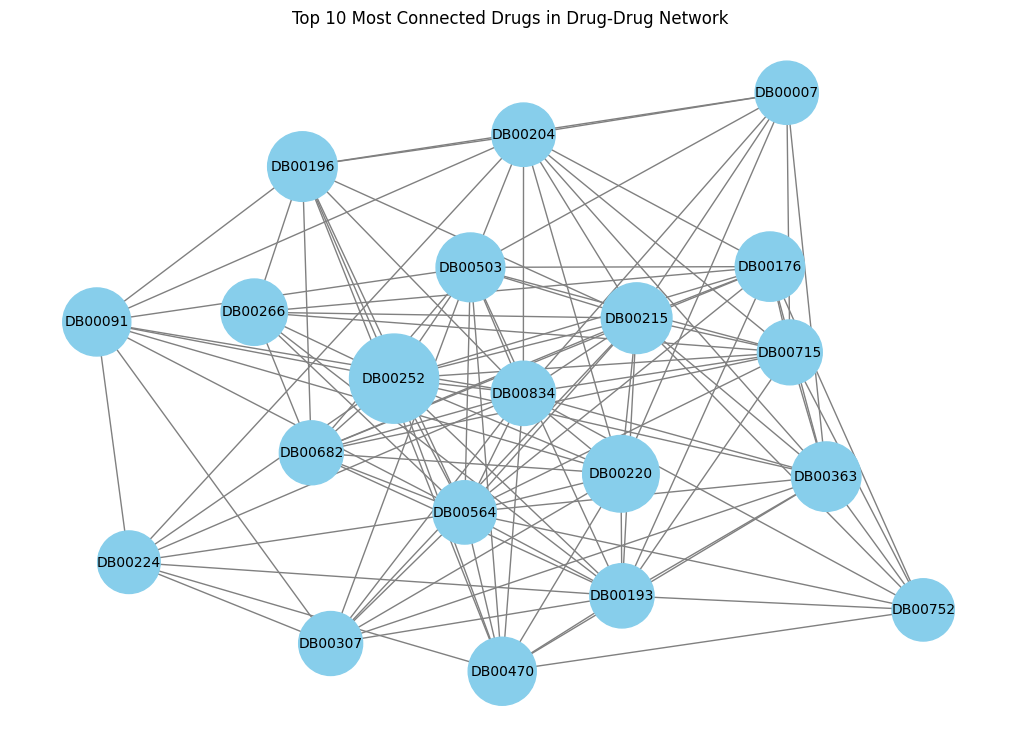

In [ ]:
# ✅ Fixed AQL Query for Top 10 Most Connected Drugs
query = '''
FOR edge IN `drug-drug`
COLLECT drug = PARSE_IDENTIFIER(edge._from).key WITH COUNT INTO count
SORT count DESC
LIMIT 20
RETURN { drug: drug, interactions: count }
'''

# Execute the query
cursor = db.aql.execute(query)
data = list(cursor)

# Initialize Graph
G = nx.Graph()

# Add Nodes (Drugs)
for item in data:
    G.add_node(item["drug"], size=item["interactions"])

# Get the top 10 drug IDs
drug_ids = [d["drug"] for d in data]

edge_query = '''
FOR edge IN `drug-drug`
FILTER PARSE_IDENTIFIER(edge._from).key IN @drug_ids 
   AND PARSE_IDENTIFIER(edge._to).key IN @drug_ids
RETURN edge
'''

edges_cursor = db.aql.execute(edge_query, bind_vars={"drug_ids": drug_ids})

for edge in edges_cursor:
    src = edge["_from"].split("/")[1]  # Extract `_key` from `drug/Aspirin`
    dst = edge["_to"].split("/")[1]  # Extract `_key` from `drug/Ibuprofen`
    G.add_edge(src, dst)

plt.figure(figsize=(10, 7))
node_sizes = [G.nodes[n]["size"] * 10 for n in G.nodes]  # Scale node sizes

pos = nx.spring_layout(G, seed=42)  # Spring layout for better spacing
nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color="skyblue", edge_color="gray", font_size=10)

plt.title("Top 10 Most Connected Drugs in Drug-Drug Network")
plt.show()

